## 1. Bộ dữ liệu

> * Bộ dữ liệu được sử dụng trong dự án này là ***một phần*** của một bộ dữ liệu gốc chứa các đánh giá sản phẩm và metadata từ Amazon, bao gồm **142.8 triệu** đánh giá từ tháng 5 năm 1996 đến tháng 7 năm 2014. [Amazon product data](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html)
>   
> * Bộ dữ liệu này bao gồm các đánh giá (điểm đánh giá, văn bản, số phiếu bầu hữu ích), metadata sản phẩm (mô tả, thông tin danh mục, giá cả, thương hiệu, và đặc điểm hình ảnh), và liên kết (đồ thị sản phẩm được xem và được mua cùng).
>
> * Chúng ta làm việc với dữ liệu về các sản phẩm làm đẹp (Beauty Products), với 2 dataset như sau:



**1. meta_Beauty.json.gz**: chứa 259,204 thông tin về các sản phẩm.

**2. ratings_Beauty.csv**: chứa 2,023,070 đánh giá từ người dùng cho các sản phẩm.

### Mục tiêu: xây dựng Hệ gợi ý sản phẩm cho người dùng theo 2 phương pháp: Collaborative Filtering

## 2. Tiền xử lý dữ liệu

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use("ggplot")


### 2.1. Đọc dữ liệu thô

In [6]:
file_path = './dataset/ratings_Beauty.csv'
amazon_ratings = pd.read_csv(file_path)
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()


,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [7]:
amazon_ratings.shape

(2023070, 4)

### 2.2. Tạo Utility Matrix

##### Trong hệ thống gợi ý, một trong những phương pháp phổ biến để dự đoán rating cho một sản phẩm là sử dụng độ đo tương đồng giữa các sản phẩm. Cách tiếp cận này dựa trên ý tưởng của thuật toán **K-Nearest Neighbors (KNN)**, một thuật toán học máy không giám sát cơ bản được sử dụng rộng rãi trong các bài toán phân loại và hồi quy. Dưới đây là các bước chi tiết thực hiện:


In [8]:
amazon_ratings1 = amazon_ratings.head(100000)

##### Đầu tiên, tạo một Utility Matrix từ dữ liệu đánh giá của người dùng, trong đó mỗi hàng tương ứng với một sản phẩm và mỗi cột tương ứng với một người dùng. Giá trị trong matrix là rating mà người dùng dành cho sản phẩm đó.

In [9]:
# Tạo utility matrix
utility_matrix = amazon_ratings1.pivot(index='ProductId', columns='UserId', values='Rating')

In [10]:
utility_matrix

UserId,A00205921JHJK5X9LNP42,A00473363TJ8YSZ3YAGG9,A00700212KB3K0MVESPIY,A0081289HG0BXFQJQUWW,A01247753D6GFZD87MUV8,A01379141PEJ6FIH7UH38,A0143622X8ZC66HZXLUP,A01437583CZ7V02UKZQ5S,A01456542S5QPYUEGJXR8,A01907982I6OHXDYN5HD6,...,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZS7W015QH2L,AZZSAMMJPJKJ1,AZZSNN1LC94VF,AZZTJQ7CQZUD8,AZZVCBG5G4EV8,AZZWJ3LICUEKJ,AZZWPNME0GQZ2,AZZZLM1E5JJ8C
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0558925278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0733001998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0737104473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0762451459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B0002VNKRM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B0002VNKSG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B0002VNLG2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
utility_matrix.shape

(6384, 91656)

##### Chuẩn hóa Utility Matrix: Tính toán trung bình các rating cho mỗi sản phẩm và trừ đi giá trị trung bình này từ các rating hiện tại. Việc này giúp giảm ảnh hưởng của sự khác biệt về thang điểm đánh giá giữa các sản phẩm.

In [12]:
# Tính trung bình chỉ từ các giá trị đã có
mean_ratings = utility_matrix.mean(axis=1, skipna=True)

# Chuẩn hóa utility matrix bằng cách trừ đi trung bình
normalized_matrix = utility_matrix.sub(mean_ratings, axis=0)

# Fill các giá trị missing bằng 0 sau khi chuẩn hóa
normalized_matrix = normalized_matrix.fillna(0)

In [13]:
# Hiển thị normalized matrix
normalized_matrix.head(100000)


UserId,A00205921JHJK5X9LNP42,A00473363TJ8YSZ3YAGG9,A00700212KB3K0MVESPIY,A0081289HG0BXFQJQUWW,A01247753D6GFZD87MUV8,A01379141PEJ6FIH7UH38,A0143622X8ZC66HZXLUP,A01437583CZ7V02UKZQ5S,A01456542S5QPYUEGJXR8,A01907982I6OHXDYN5HD6,...,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZS7W015QH2L,AZZSAMMJPJKJ1,AZZSNN1LC94VF,AZZTJQ7CQZUD8,AZZVCBG5G4EV8,AZZWJ3LICUEKJ,AZZWPNME0GQZ2,AZZZLM1E5JJ8C
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0558925278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0733001998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0737104473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0762451459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B0002VNKRM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0002VNKSG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0002VNLG2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Chuyển đổi sang định dạng sparse matrix để tiết kiệm bộ nhớ
sparse_matrix = csr_matrix(normalized_matrix.values)

##### Sử dụng ma trận đã chuẩn hóa để tính toán độ đo tương đồng giữa các sản phẩm. Ở đây chúng ta dùng độ đo tương đồng $cosine$. Độ đo $cosine$ cho biết mức độ tương tự giữa hai sản phẩm dựa trên góc giữa hai vector rating của chúng trong không gian nhiều chiều.


$$
\text{cosine{\_similarity}(i, j)} = \frac{\sum_{u \in U} r_{ui} \cdot r_{uj}}{\sqrt{\sum_{u \in U} r_{ui}^2} \cdot \sqrt{\sum_{u \in U} r_{uj}^2}}
$$

In [15]:
# Tính toán độ đo tương đồng cosine giữa các sản phẩm
item_similarity = cosine_similarity(sparse_matrix)
# Đặt tất cả các giá trị trên đường chéo bằng 1
np.fill_diagonal(item_similarity, 1)


##### Kết quả của việc tính toán độ đo tương đồng cosine là một ma trận tương đồng, trong đó mỗi phần tử $(i$,$j)$ biểu thị độ tương đồng giữa sản phẩm $𝑖$ sản phẩm $j$.

In [16]:
# Chuyển đổi matrix tương đồng sang DataFrame để dễ đọc
item_similarity_df = pd.DataFrame(item_similarity, index=utility_matrix.index, columns=utility_matrix.index)

# Hiển thị item similarity matrix
item_similarity_df.head(10)

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B0002VJIH8,B0002VJTGS,B0002VNKPO,B0002VNKPY,B0002VNKQS,B0002VNKRM,B0002VNKSG,B0002VNLG2,B0002VNZS6,B0002VQ0WO
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0558925278,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0733001998,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0737104473,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0762451459,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304139212,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304139220,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130414089X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130414643X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Các ô trên đường chéo đều bằng 1 vì đó là $cos$ của góc giữa 1 vector và chính nó, tức $cos(0)=1$.

##### Tiếp theo, xây dựng hàm dự đoán raings.
- Hàm sẽ thực hiện phán đoán rating của người dùng $u$ cho sản phẩm $i$, dựa trên $k$ sản phẩm tương đồng với nó nhất (theo độ đo cosine ở trên) mà người dùng u đã đánh giá (K-Nearest Neighbors).

- Rating phán đoán sẽ được tính bằng trung bình có trọng số của $k$ sản phẩm đó.

In [17]:
def predict_rating(user_id, item_id, utility_matrix, item_similarity_df, k=5):
    if item_id not in utility_matrix.index or user_id not in utility_matrix.columns:
        return None
    
    user_ratings = utility_matrix[user_id].dropna()
    
    if user_ratings.empty:
        return None
    
    if item_id in user_ratings.index:
        return utility_matrix.at[item_id, user_id]
    
    user_rated_items = user_ratings.index
    similar_items = item_similarity_df.loc[user_rated_items, item_id].nlargest(k + 1).index
    similar_items = similar_items[similar_items != item_id]
    
    if not similar_items.empty:
        sim_scores = item_similarity_df.loc[similar_items, item_id]
        user_sim_ratings = user_ratings[similar_items]
        
        weighted_sum = np.dot(user_sim_ratings, sim_scores)
        sim_sum = np.abs(sim_scores).sum()
        
        if sim_sum != 0:
            return weighted_sum / sim_sum
    
    user_mean_rating = user_ratings.mean()
    item_mean_rating = utility_matrix.loc[item_id].mean()
    
    if not np.isnan(user_mean_rating) and not np.isnan(item_mean_rating):
        return (user_mean_rating + item_mean_rating) / 2
    elif not np.isnan(user_mean_rating):
        return user_mean_rating
    elif not np.isnan(item_mean_rating):
        return item_mean_rating
    else:
        return None


In [18]:
# Ví dụ cụ thể: Dự đoán rating của user 'A3OMF1C8HBGJEN' cho sản phẩm 'B0002UBEI0'
user_id = 'A3OMF1C8HBGJEN'
item_id = 'B0002UBEI0'

predicted_rating = predict_rating(user_id, item_id, utility_matrix, item_similarity_df, k=5)
print(f"Dự đoán rating của user '{user_id}' cho sản phẩm '{item_id}': {predicted_rating}")

Dự đoán rating của user 'A3OMF1C8HBGJEN' cho sản phẩm 'B0002UBEI0': 2.083333333333333


## 3. Đánh giá mô hình

#####  Chúng ta dùng một số phương pháp và chỉ số đo lường phổ biến trong hệ thống gợi ý như Root Mean Squared Error (RMSE) và Mean Absolute Error (MAE).

##### Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra và dự đoán rating trên tập kiểm tra:

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
train_data, test_data = train_test_split(amazon_ratings1, test_size=0.2, random_state=42)

# Tạo utility matrix cho tập huấn luyện
train_utility_matrix = train_data.pivot(index='ProductId', columns='UserId', values='Rating')

# Tạo item similarity matrix cho tập huấn luyện
train_mean_ratings = train_utility_matrix.mean(axis=1, skipna=True)
train_normalized_matrix = train_utility_matrix.sub(train_mean_ratings, axis=0).fillna(0)
train_sparse_matrix = csr_matrix(train_normalized_matrix.values)
train_item_similarity = cosine_similarity(train_sparse_matrix)
np.fill_diagonal(train_item_similarity, 1)
train_item_similarity_df = pd.DataFrame(train_item_similarity, index=train_utility_matrix.index, columns=train_utility_matrix.index)

# Dự đoán rating trên tập kiểm tra
test_user_ids = test_data['UserId'].tolist()
test_product_ids = test_data['ProductId'].tolist()
test_ratings = test_data['Rating'].tolist()


##### Tính toán các chỉ số đánh giá:

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

predicted_ratings = []
for user_id, item_id in zip(test_user_ids, test_product_ids):
    pred_rating = predict_rating(user_id, item_id, train_utility_matrix, train_item_similarity_df, k=2)
    predicted_ratings.append(pred_rating)

# Loại bỏ các giá trị None từ danh sách dự đoán và giá trị thực tế tương ứng
filtered_predicted_ratings = [pred for pred in predicted_ratings if pred is not None]
filtered_test_ratings = [actual for pred, actual in zip(predicted_ratings, test_ratings) if pred is not None]

# Tính toán RMSE và MAE
rmse = root_mean_squared_error(filtered_test_ratings, filtered_predicted_ratings)
mae = mean_absolute_error(filtered_test_ratings, filtered_predicted_ratings)

# Hiển thị kết quả
print("Evaluation Metrics for k=2")
print("============================")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Evaluation Metrics for k=2
Root Mean Squared Error (RMSE): 2.5296
Mean Absolute Error (MAE): 1.3711


##### Thử nghiệm với các giá trị khác nhau của k để tìm giá trị tối ưu:

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_model(utility_matrix, item_similarity_df, test_data, k_values):
    results = {}
    for k in k_values:
        predicted_ratings = []
        for user_id, item_id in zip(test_user_ids, test_product_ids):
            pred_rating = predict_rating(user_id, item_id, utility_matrix, item_similarity_df, k=k)
            predicted_ratings.append(pred_rating)

        filtered_predicted_ratings = [pred for pred in predicted_ratings if pred is not None]
        filtered_test_ratings = [actual for pred, actual in zip(predicted_ratings, test_ratings) if pred is not None]

        rmse = root_mean_squared_error(filtered_test_ratings, filtered_predicted_ratings)
        mae = mean_absolute_error(filtered_test_ratings, filtered_predicted_ratings)
        results[k] = {'RMSE': rmse, 'MAE': mae}

    return results

k_values = [1, 3, 5, 7, 10]
results = evaluate_model(train_utility_matrix, train_item_similarity_df, test_data, k_values)

for k, metrics in results.items():
    print(f'k={k}: RMSE={metrics["RMSE"]}, MAE={metrics["MAE"]}')


k=1: RMSE=2.419867334164374, MAE=1.3112136453783894
k=3: RMSE=2.5440555967083647, MAE=1.3807611744595947
k=5: RMSE=2.5767151918705906, MAE=1.3996456541484679
k=7: RMSE=2.586036774652009, MAE=1.4038359012830577
k=10: RMSE=2.594554349347366, MAE=1.4104112619009266


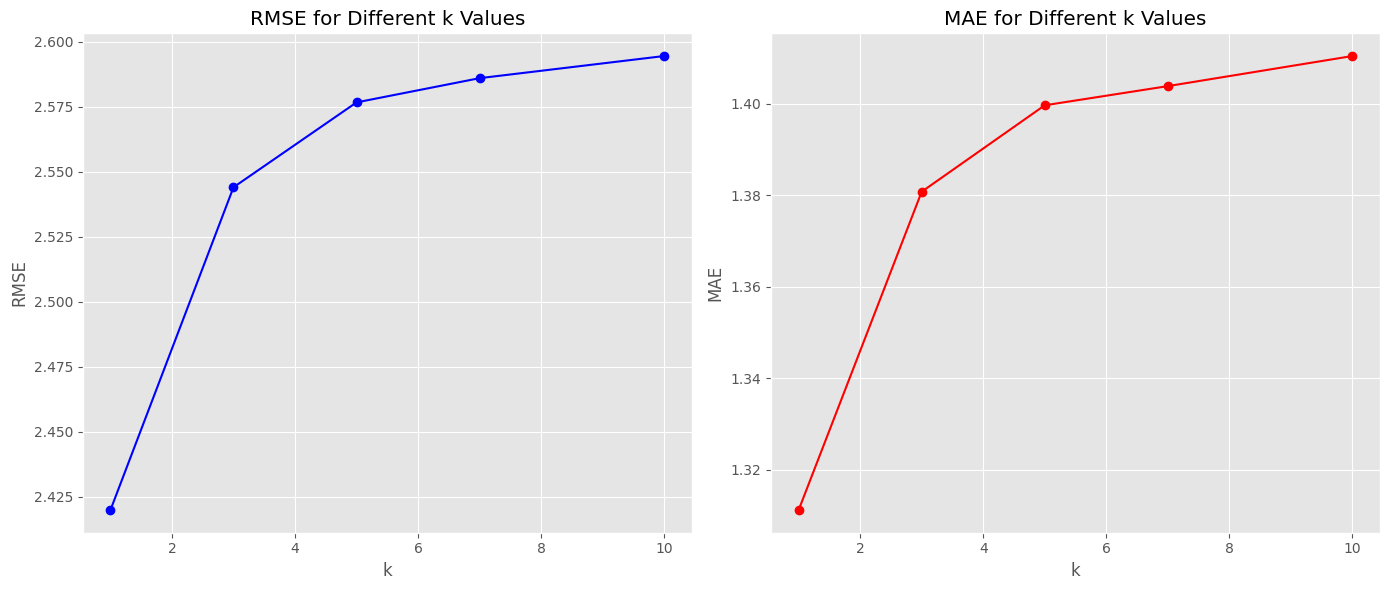

In [22]:
import matplotlib.pyplot as plt

# Trực quan hóa kết quả RMSE và MAE
k_values = [1, 3, 5, 7, 10]
results = evaluate_model(train_utility_matrix, train_item_similarity_df, test_data, k_values)

rmse_values = [metrics['RMSE'] for metrics in results.values()]
mae_values = [metrics['MAE'] for metrics in results.values()]

plt.figure(figsize=(14, 6))

# Biểu đồ RMSE
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE for Different k Values')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.grid(True)

# Biểu đồ MAE
plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, marker='o', linestyle='-', color='r')
plt.title('MAE for Different k Values')
plt.xlabel('k')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()


##### Cả RMSE và MAE đều tăng khi giá trị k tăng. Điều này có thể cho thấy rằng việc tăng số lượng sản phẩm tương tự (k) không cải thiện, mà ngược lại còn làm giảm độ chính xác của mô hình dự đoán.

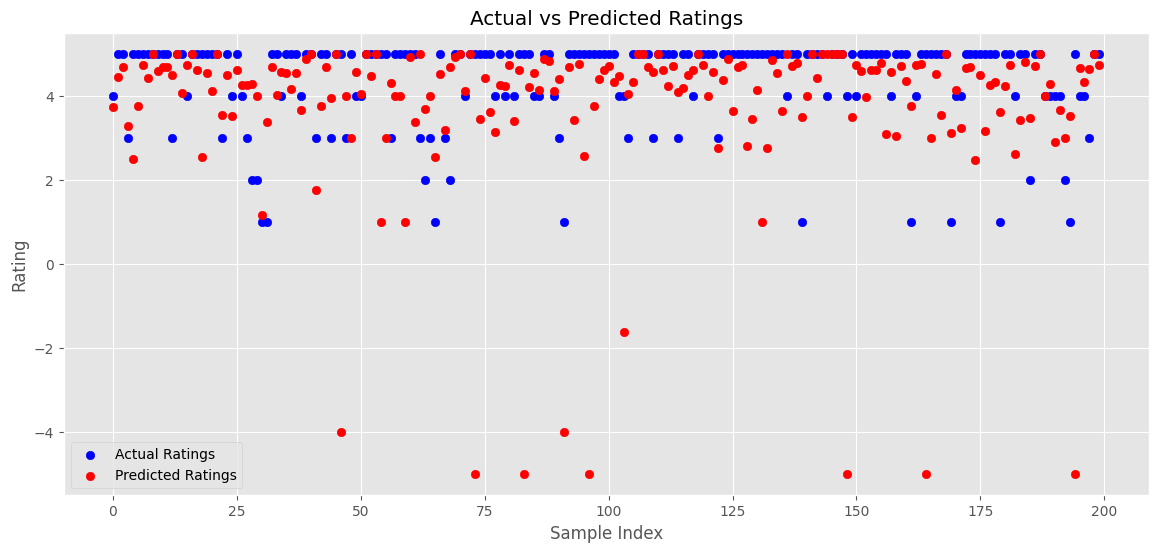

In [26]:
# Chọn một vài mẫu để trực quan hóa
sample_size = 200
sample_indices = np.random.choice(range(len(filtered_test_ratings)), size=sample_size, replace=False)

sample_test_ratings = [filtered_test_ratings[i] for i in sample_indices]
sample_predicted_ratings = [filtered_predicted_ratings[i] for i in sample_indices]

plt.figure(figsize=(14, 6))

# Biểu đồ so sánh giá trị thực tế và giá trị dự đoán
plt.scatter(range(sample_size), sample_test_ratings, color='blue', label='Actual Ratings')
plt.scatter(range(sample_size), sample_predicted_ratings, color='red', label='Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Sample Index')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
plt.show()

##### Phân bố rating:
- Các giá trị rating thực tế tập trung nhiều ở mức 4 và 5, cho thấy người dùng thường xuyên đánh giá sản phẩm cao.

- Các giá trị rating dự đoán cũng tập trung nhiều ở mức 4 và 5, cho thấy mô hình dự đoán tương đối gần với phân bố rating thực tế.

##### Sai số dự đoán:
- Có một số điểm rating dự đoán lệch xa so với giá trị thực tế, đặc biệt là ở các vị trí có rating thực tế thấp (dưới 3). Điều này có thể dẫn đến giá trị RMSE và MAE cao.

- Các điểm rating thực tế và dự đoán khác biệt rõ rệt, cho thấy mô hình cần cải thiện để giảm sai số dự đoán.
##### Biểu đồ phân tán cho thấy sự khác biệt giữa giá trị thực tế và dự đoán tại nhiều vị trí. Các điểm phân tán không khớp hoàn toàn, cho thấy mô hình dự đoán không hoàn hảo và có sai số.